# XGBoost on GPU, no categories, with dates, including "onetimers"
## Predicting the time difference to the next repurchase

### Methods & Settings

In [6]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import gc
import joblib

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

pd.set_option('display.max_rows', 250)
pd.set_option('display.min_rows', 25)

####
# prints memory usage
def show_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB\n'.format(start_mem))
    return

####
# seperates features from label (y must be last column)
def sep_X_y(df_train, df_test):
    X_train = df_train.iloc[:,0:-1] # extracts all rows [:] and columns from 0 to next-to-last [0:-1]
    y_train = df_train.iloc[:,-1] # extracts all rows [:] and only last column [-1]
    X_test = df_test.iloc[:,0:-1]
    y_test = df_test.iloc[:,-1]
    
    return [X_train, y_train, X_test, y_test]

####
# split training and test set from given dataframe with dates as boundaries
def dt_train_test_split(df, dt_start_train, dt_end_train, dt_start_test, dt_end_test):
    print('Splitting dataframe...\n')
    # get indices from desired boundaries
    idx_start_train = df.date.searchsorted(pd.to_datetime(dt_start_train), side='left') # list needs to be sorted already for searchsorted
    idx_end_train = df.date.searchsorted(pd.to_datetime(dt_end_train) + pd.Timedelta(days=1), side='left')
    idx_start_test = df.date.searchsorted(pd.to_datetime(dt_start_test), side='left')
    idx_end_test = df.date.searchsorted(pd.to_datetime(dt_end_test) + pd.Timedelta(days=1), side='left')
    
    train = df.iloc[idx_start_train:idx_end_train]
    test = df.iloc[idx_start_test:idx_end_test]
    
    train.drop(columns=['date'], axis=0, inplace=True)
    test.drop(columns=['date'], axis=0, inplace=True)
    
    return sep_X_y(train, test)

####
# trains XGB model (classifier)
def train_xgb(X, y):
    X_train = X
    y_train = y
    
    print('Fitting model...\n')
    model = XGBRegressor(tree_method='gpu_hist', gpu_id=0)
    fitted_model = model.fit(X_train, y_train)
    
    print('Plotting feature importance for "gain". Do not rely on that.\n')
    print('https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27\n')
    xgb.plot_importance(model, importance_type='gain')
    plt.show()
    
    # GRAPHVIZ (software + pip package) needed for tree plotting
    #fig, ax = plt.subplots(figsize=(30, 30))
    #xgb.plot_tree(model, num_trees=0, ax=ax, rankdir='LR')
    #plt.show()
    
    return fitted_model

####
# predicts labels of training and test with given model
def predict_values(model, X_train, y_train, X_test, y_test):
    print('Predicting values...\n')
    # predict y values
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    
    # get accuracies
    model_train = mean_squared_error(y_train, y_train_pred)
    model_test = mean_squared_error(y_test, y_test_pred)
    
    
    """
    #get precision
    model_train_precision = precision_score(y_train, y_train_pred, average)
    model_test_precision = precision_score(y_test, y_test_pred)
    """
    # print info about accuracies
    print(f'\n XGboost train/test accuracies: '
         f'{model_train:.3f}/{model_test:.3f}')
    
    # return predicted values
    return [y_train_pred, y_test_pred]

####
# concatenates prediction with actual target for evaluation
def evaluate_pred(X, y, y_pred):
    # create dataframe from test-prediction with index from X_test
    df_y_pred = pd.DataFrame(y_pred, columns=['nextBuyIn_pred'], index=X.index, dtype=np.int8)

    # concatenate X, y, y_pred (put columns next to each other)
    df_eval = pd.concat([X, y, df_y_pred], axis=1)
    
    return df_eval

####
# executes all needed functions of the above with given training and test data and provided train method
def execute_pipeline(train_method, df, list_of_four_df_boundaries):
    b = list_of_four_df_boundaries
    # split dataframe in train/test and X/y
    X_train, y_train, X_test, y_test = dt_train_test_split(df, b[0], b[1], b[2], b[3])
    
    #train model
    model = train_method(X_train, y_train)    
    
    # make predictions
    pred_train, pred_test = predict_values(model, X_train, y_train, X_test, y_test)
    
    print('\nExecuted pipeline.\nEvaluate with "evaluate_pred(X, y, y_pred)"\n')
    return [pred_train, pred_test, X_train, y_train, X_test, y_test]

In [2]:
file = r'E:\OneDrive\Arbeit\Repos\DMC2022\Kevin\csv\09_orders_noItemsNotOrdered_evalCats_diffToNxtPurch.csv'

columns = ['date',
           'userID', 
           'itemID',
           'nextBuyInDays',
           'nextBuyInWeeks',
           'order', 
           'brand', 
           'feature_1', 
           'feature_2', 
           'feature_3', 
           'feature_4', 
           'feature_5'
          ]

dtype = {'userID':np.uint32,
         'itemID':np.uint32,
         'nextBuyInDays':np.uint16,
         'nextBuyInWeeks':np.uint8,
         'order':np.uint8,
         'brand':np.int16,
         'feature_1':np.int8,
         'feature_2':np.uint8,
         'feature_3':np.int16,
         'feature_4':np.int8,
         'feature_5':np.int16}

---

# Predicting Days

## Preparation

In [3]:
df = pd.read_csv(file, usecols=columns, sep='|', dtype=dtype, nrows=None, converters={'date':pd.to_datetime})
show_mem_usage(df)

Memory usage of dataframe is 29.64 MB



Creating additional time related features out of 'date' column.

In [4]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['weekOfYear'] = df['date'].dt.weekofyear

Drop the label that is NOT needed. Then append label column at end.

In [5]:
df.drop(columns=['nextBuyInWeeks'], axis=0, inplace=True)
col = df.pop("nextBuyInDays") # target variable
df.insert(len(df.columns), col.name, col)

## Training & Prediction

Pipeline needs training method, dataframe and dates to split dataframe in training and test set.

Splitting dataframe...

Fitting model...

Plotting feature importance for "gain". Do not rely on that.

https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27



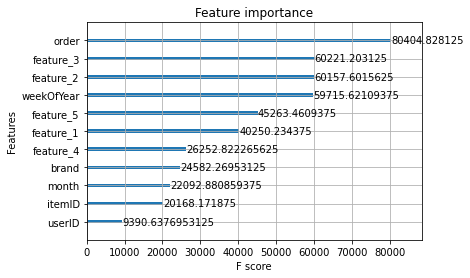

Predicting values...


 XGboost train/test accuracies: 1466.246/282.262

Executed pipeline.
Evaluate with "evaluate_pred(X, y, y_pred)"

CPU times: total: 10.4 s
Wall time: 1.42 s


In [7]:
%%time
pred_train, pred_test, X_train, y_train, X_test, y_test = execute_pipeline(train_xgb, df, [
    '2020-06-01', # start train set
    '2020-10-31', # end train set
    '2020-11-01', # start test set
    '2020-11-30'  # end test set
])

In [26]:
model_train_precision = precision_score(y_train, pred_train, average='macro')
model_test_precision = precision_score(y_test, pred_test, average='macro')
model_train_precision, model_test_precision

(0.9384566922952646, 0.15834794358364634)

In [30]:
model_train_precision = balanced_accuracy_score(y_train, pred_train)
model_test_precision = balanced_accuracy_score(y_test, pred_test)
model_train_precision, model_test_precision

(0.05792966073537888, 0.0728823132788233)

## Evaluation

### train set

In [8]:
df_eval_train = evaluate_pred(X_train, y_train, pred_train)
df_eval_train.head(10)

,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,year,month,weekOfYear,nextBuyInDays,nextBuyIn_pred
0,4,18860,1,603,10,0,536,3,147,2020,6,23,0,8
1,4,30779,1,406,10,1,503,3,17,2020,6,23,0,24
2,20,18613,2,1111,4,3,444,3,11,2020,6,23,0,35
3,55,9547,1,671,10,0,506,0,17,2020,6,23,0,22
4,55,10844,1,1180,10,0,192,0,96,2020,6,23,0,13
5,55,17912,1,342,6,0,190,0,96,2020,6,23,0,6
6,55,24763,1,186,6,0,207,0,17,2020,6,23,0,16
7,76,2787,1,1324,10,0,421,3,3,2020,6,23,0,35
8,76,23050,1,1411,4,0,22,0,151,2020,6,23,169,59
9,76,26645,1,648,10,0,358,3,24,2020,6,23,0,31


### test set

In [9]:
df_eval_test = evaluate_pred(X_test, y_test, pred_test)
df_eval_test.head(10)

,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,year,month,weekOfYear,nextBuyInDays,nextBuyIn_pred
636352,11,2318,2,1232,6,0,496,0,146,2020,11,44,0,18
636353,11,8115,1,105,6,1,495,3,-1,2020,11,44,0,2
636354,11,11356,1,1232,6,0,496,0,146,2020,11,44,0,10
636355,11,12054,1,398,6,1,495,0,146,2020,11,44,0,11
636356,11,12214,1,1383,1,3,513,0,78,2020,11,44,0,-3
636357,11,30757,2,105,6,1,495,3,-1,2020,11,44,0,3
636358,11,32342,1,1156,4,1,496,0,33,2020,11,44,0,5
636359,103,18350,1,186,4,0,318,0,163,2020,11,44,0,4
636360,103,32403,1,829,6,0,395,3,17,2020,11,44,0,6
636361,152,3560,1,1154,10,0,503,0,17,2020,11,44,0,5


In [10]:
rowcount = len(df_eval_test)
should = len(df_eval_test.loc[(df_eval_test.nextBuyInDays != 0)])
is_ = len(df_eval_test.loc[(df_eval_test.nextBuyInDays != 0) & (df_eval_test.nextBuyInDays == df_eval_test.nextBuyIn_pred)]) 

print(f'row count of set:\t\t\t\t\t {rowcount}')
print(f'rows where label is not 0:\t\t\t\t {should} \t ({should/rowcount*100:.3f} % of all rows in set)')
print(f'rows where label was predicted correctly AND not 0:\t {is_} \t ({is_/should*100:.3f} % of rows where label is not 0)')

row count of set:					 130779
rows where label is not 0:				 16281 	 (12.449 % of all rows in set)
rows where label was predicted correctly AND not 0:	 125 	 (0.768 % of rows where label is actually 0)


---

---

# Predicting Weeks

## Preparation

In [11]:
df = pd.read_csv(file, usecols=columns, sep='|', dtype=dtype, nrows=None, converters={'date':pd.to_datetime})
show_mem_usage(df)

Memory usage of dataframe is 29.64 MB



Creating additional time related features out of 'date' column.

In [12]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['weekOfYear'] = df['date'].dt.weekofyear

Drop the label that is NOT needed. Then append label column at end.

In [13]:
df.drop(columns=['nextBuyInDays'], axis=0, inplace=True)
col = df.pop("nextBuyInWeeks") # target variable
df.insert(len(df.columns), col.name, col)

## Training & Prediction

Pipeline needs training method, dataframe and dates to split dataframe in training and test set.

Splitting dataframe...

Fitting model...

Plotting feature importance for "gain". Do not rely on that.

https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27



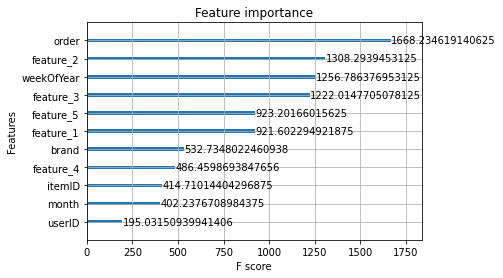

Predicting values...


 XGboost train/test accuracies: 29.956/5.773

Executed pipeline.
Evaluate with "evaluate_pred(X, y, y_pred)"

CPU times: total: 10.8 s
Wall time: 1.14 s


In [14]:
%%time
pred_train, pred_test, X_train, y_train, X_test, y_test = execute_pipeline(train_xgb, df, [
    '2020-06-01', # start train set
    '2020-10-31', # end train set
    '2020-11-01', # start test set
    '2020-11-30'  # end test set
])

## Evaluation

### train set

In [15]:
df_eval_train = evaluate_pred(X_train, y_train, pred_train)
df_eval_train.head(10)

,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,year,month,weekOfYear,nextBuyInWeeks,nextBuyIn_pred
0,4,18860,1,603,10,0,536,3,147,2020,6,23,0,3
1,4,30779,1,406,10,1,503,3,17,2020,6,23,0,4
2,20,18613,2,1111,4,3,444,3,11,2020,6,23,0,3
3,55,9547,1,671,10,0,506,0,17,2020,6,23,0,3
4,55,10844,1,1180,10,0,192,0,96,2020,6,23,0,1
5,55,17912,1,342,6,0,190,0,96,2020,6,23,0,1
6,55,24763,1,186,6,0,207,0,17,2020,6,23,0,1
7,76,2787,1,1324,10,0,421,3,3,2020,6,23,0,4
8,76,23050,1,1411,4,0,22,0,151,2020,6,23,24,5
9,76,26645,1,648,10,0,358,3,24,2020,6,23,0,1


### test set

In [35]:
df_eval_train.loc[(df_eval_train.itemID == 751) ]

,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,year,month,weekOfYear,nextBuyInWeeks,nextBuyIn_pred
849,7417,751,1,135,4,0,487,3,175,2020,6,23,0,3
8838,38607,751,1,135,4,0,487,3,175,2020,6,23,14,4
25655,22159,751,1,135,4,0,487,3,175,2020,6,23,0,4
85137,26482,751,1,135,4,0,487,3,175,2020,6,25,0,4
86888,40291,751,1,135,4,0,487,3,175,2020,6,25,21,4
129793,44916,751,1,135,4,0,487,3,175,2020,6,27,0,4
134418,43550,751,1,135,4,0,487,3,175,2020,7,27,0,3
158306,7083,751,1,135,4,0,487,3,175,2020,7,28,0,3
168305,18235,751,3,135,4,0,487,3,175,2020,7,28,0,5
184784,42297,751,1,135,4,0,487,3,175,2020,7,28,0,3


In [32]:
df_eval_test.loc[(df_eval_test.userID == 69) & (df_eval_test.itemID == 751) ]

,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,year,month,weekOfYear,nextBuyInWeeks,nextBuyIn_pred
638239,69,751,1,135,4,0,487,3,175,2020,11,45,4,4


In [30]:
df_eval_test.loc[(df_eval_test.userID == 3599) & (df_eval_test.itemID == 26162) ]

,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,year,month,weekOfYear,nextBuyInWeeks,nextBuyIn_pred
636498,3599,26162,2,703,4,0,335,3,89,2020,11,44,2,2
675565,3599,26162,2,703,4,0,335,3,89,2020,11,46,2,2
754616,3599,26162,2,703,4,0,335,3,89,2020,11,48,2,2


In [27]:
df_eval_test = evaluate_pred(X_test, y_test, pred_test)
df_eval_test.loc[(df_eval_test.nextBuyInWeeks == df_eval_test.nextBuyIn_pred) & (df_eval_test.nextBuyInWeeks != 0)]

,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,year,month,weekOfYear,nextBuyInWeeks,nextBuyIn_pred
636498,3599,26162,2,703,4,0,335,3,89,2020,11,44,2,2
636717,9239,31808,2,558,4,0,41,3,44,2020,11,44,3,3
637047,17860,29044,1,615,4,0,487,3,106,2020,11,44,1,1
637077,19251,8772,1,1023,10,3,503,0,17,2020,11,44,2,2
637366,24756,27866,5,127,10,0,345,0,95,2020,11,44,3,3
638239,69,751,1,135,4,0,487,3,175,2020,11,45,4,4
638409,1464,4849,1,453,4,2,457,-1,-1,2020,11,45,2,2
638544,2708,9262,1,618,4,1,486,0,144,2020,11,45,3,3
639845,12534,18121,2,323,10,0,243,0,132,2020,11,45,1,1
639846,12534,22142,3,523,10,0,504,0,17,2020,11,45,2,2


In [17]:
rowcount = len(df_eval_test)
should = len(df_eval_test.loc[(df_eval_test.nextBuyInWeeks != 0)])
is_ = len(df_eval_test.loc[(df_eval_test.nextBuyInWeeks != 0) & (df_eval_test.nextBuyInWeeks == df_eval_test.nextBuyIn_pred)]) 

print(f'row count of set:\t\t\t\t\t {rowcount}')
print(f'rows where label is not 0:\t\t\t\t {should} \t ({should/rowcount*100:.3f} % of all rows in set)')
print(f'rows where label was predicted correctly AND not 0:\t {is_} \t ({is_/should*100:.3f} % of rows where label is actually 0)')

row count of set:					 130779
rows where label is not 0:				 16091 	 (12.304 % of all rows in set)
rows where label was predicted correctly AND not 0:	 552 	 (3.430 % of rows where label is actually 0)


---